# ENVS615 Data Science Studio
# Exploratory Data Analysis, Unsupervised & Supervised Learning of Diamonds

---
---

## 1-Find, Prepare & Explore a Dataset

The dataset selected for analysis was the 'Diamonds' dataset found on Kaggle (2017) consisting of 53,940 round cut diamond observations. This dataset was thought to be particularly rich for performing data analysis and machine learning due to the complexity of the variables in relation to the diamond price (GIA, 2021).

The dataset was not ready for performing data analysis and hence required some pre-processing. The final dataset consisted of 53,772 observations with 10 features. This included 7 continuous and 3 categorical characteristics. These were `carat` (0.2-5.01ct.), `cut` (Fair, Good, Very Good, Premium, Ideal), `colour` (J-D), `clarity` (I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF), `price` (\\$326-\\$18,823 USD), length `x` (3.73-10.74mm), width `y` (3.68-10.54mm), depth `z` (1.07-6.98mm), `table` $(\text{table width}/y)$ (43-79%) and `depth` $2(z/x+y)$ (50.8-79.0%).

In [1]:
# All imports required:
import pandas # for performing panel data analysis
import numpy as np # for math functions
import seaborn as sns # for plots
import matplotlib.pyplot as plt # for plots
import matplotlib.gridspec as gs # for custom subplots

# Unsupervised Learning
from numpy.random import seed  # for keeping random outputs constant
from sklearn.cluster import KMeans  # for performing kmeans clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score # for evaluating model performance
from sklearn.decomposition import PCA # for dimensionality reduction
from sklearn.preprocessing import scale # for standardising data

# Supervised Learning
from sklearn.linear_model import LinearRegression #for performing OLS linear regression
from sklearn.ensemble import RandomForestRegressor  #for performing the rf reg
from sklearn import metrics  # for getitng model performance scores
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

In [2]:
# Read in the diamonds dataset 
db = pandas.read_csv("../diamonds_data.zip")

In [3]:
# Rename color column to colour 
db.rename(columns = {"color":"colour"}, inplace =True)

# Rename the first column to ID and set this as the row index
db.rename(columns = {"Unnamed: 0":"ID"}, inplace = True)
dbi = db.set_index("ID") # new obj created, indexing begins at 1 not 0

In [4]:
# Locate and remove all rows where x OR y OR z dimension is 0mm using concatenated conditional query
# because impossible to have diamond dimension as 0mm
dbi = dbi.drop(dbi.loc[(dbi["x"]==0) |   
        (dbi["y"]==0) |   
        (dbi["z"]==0),    
        :].index)
# index values remain unchanged so that removed diamonds are known
# e.g. diamond 51507 removed but 51506/8 remain in dataset, 20 incorrect observations removed

In [5]:
# Locate obs where Y value > 30mm and show all columns for this
# Found IDs for these are 24068 & 49190 & drop these from dataset as do not match with x value
# Should be similar to x since y value is another measure of diammeter
#dbi.describe()
dbi = dbi.drop(dbi.loc[dbi["y"] > 30, :].index)

# Locate obs where Z value > 30mm and show all columns for this
#dbi.loc[dbi["z"] > 30,:]
# Found one obs with ID 48411, adjust this after calculating true value using %depth equation
dbi.loc[48411, "z"]= 3.17  #adjusted from 30 to 3.17mm

# Locate obs where TABLE > 90mm and drop extreme table value,subject knowledge cannot have such large table
dbi = dbi.drop(dbi.loc[dbi["table"] > 90, :].index) 

# Locate DEPTH outliers
#dbi.plot.scatter("depth", "price")
#dbi.loc[dbi["depth"]<45,:] 
# Recalculated the depth % value from x y z - found were incorrect so adjusted these
dbi.loc[10378, "depth"]= 63.0  #recorded as 43.0, changed to 63.0 correct value
dbi.loc[6342, "depth"] = 65.7  #recorded as 44.0, changed to 65.7 correct value
dbi.loc[4519, "depth"] = 63.1  #recorded as 43.0, chnaged to 63.1 correct value

In [6]:
# Duplicate Observations & check null values
#dbi.duplicated().sum()  #There are 145 duplicates with different IDs
# Drop the duplicate observations and keep only 1st instance
dbi.drop_duplicates(inplace=True)  #dropped 145 obs

#dbi.isnull().values.any() #Returns 'False', confirms no null values 

**Dataset Exploration**

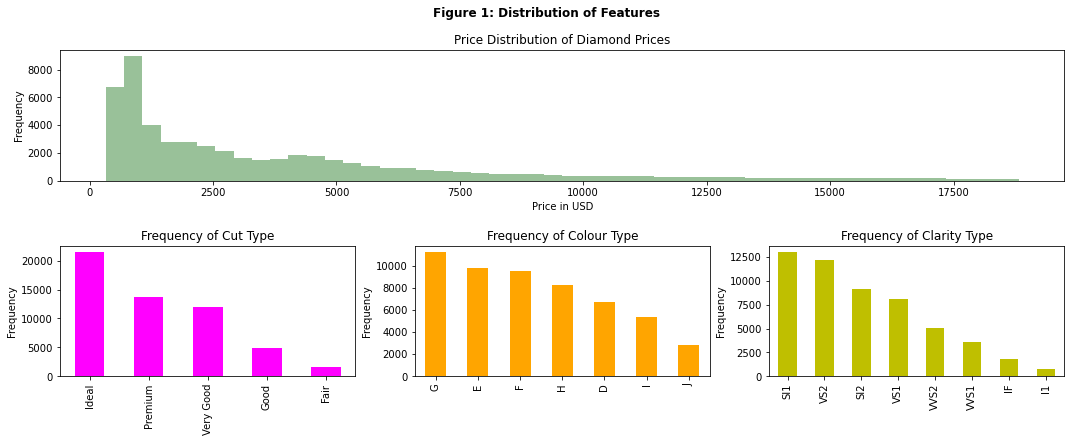

In [7]:
# Figure 1 to show price distribution and categorical variable frequencies 
fig = plt.figure(figsize=(18,6))
fig.suptitle("Figure 1: Distribution of Features", weight ="bold") # main title

gs = gs.GridSpec(2, 3, wspace=0.2, hspace=0.5) # create custom 2x3 grid
ax0 = fig.add_subplot(gs[0, :]) # full first row
ax1 = fig.add_subplot(gs[1, 0]) # second row, first col
ax2 = fig.add_subplot(gs[1, 1]) # second row, second col
ax3 = fig.add_subplot(gs[1, 2]) # second row, third col

# Price distribution using distplot on first row
sns.distplot(dbi["price"], kde=False, color="darkgreen", ax=ax0)
ax0.set_title("Price Distribution of Diamond Prices")
ax0.set_xlabel("Price in USD")
ax0.set_ylabel("Frequency")

# Bar charts showing cut, colour, clarity frequency, from most - least count 
dbi["cut"].value_counts().plot.bar(cmap="spring", ax=ax1)
ax1.set_title("Frequency of Cut Type")
ax1.set_ylabel("Frequency")

dbi["colour"].value_counts().plot.bar(color = "orange", ax=ax2)
ax2.set_title("Frequency of Colour Type")
ax2.set_ylabel("Frequency")

dbi["clarity"].value_counts().plot.bar(color = "y", ax=ax3)
ax3.set_title("Frequency of Clarity Type")
ax3.set_ylabel("Frequency")

plt.show()

In [8]:
%%capture
# Code used to investigate carat distribution
sns.distplot(dbi["carat"], kde=False, color="darkgreen")

# Code used to understand correlations between numerical variables
dbi.corr();

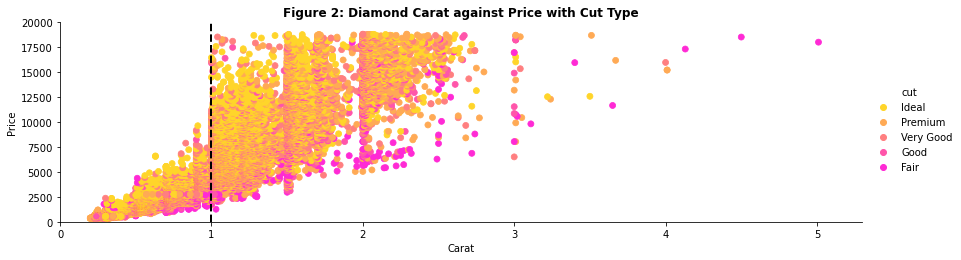

In [9]:
# Figure 2 to show scatter plot of carat vs price using seaborn & shade depending on cut
ax = sns.relplot(x="carat",
            y="price",
            hue="cut",
            hue_order = ["Ideal","Premium", "Very Good", "Good", "Fair"],
            palette = "spring_r",
            edgecolor = None,
            height = 3.5,
            aspect = 3.5,
            data=dbi)
# Title of plot
plt.title("Figure 2: Diamond Carat against Price with Cut Type", weight="bold")
             
# Control x and y label and limits
ax.set(xlabel="Carat", ylabel="Price")
ax.set(xlim=(0,5.3),ylim=(0, 20000))

# Show where price begins to vary increasingly with a black dotted line at x=1
plt.plot([1, 1], [0, 20000], "k--", lw=2);

From Figure 1, the price of the diamonds is negatively skewed and majority of the diamonds in the dataset cost below \\$2500. Furthermore, the most popular cut, colour and clarity types are ‘Ideal’, ‘G’ and ‘SI1’ and the least popular are ‘Fair’, ‘J’ and ‘I1’ respectively. 
It was found that carat and price have a strong positive linear correlation of 0.92 and that carat also has a negatively skewed distribution, with majority of diamonds below 1ct. Intuitively, it is expected that the price of a diamond increases as its weight increases.

However, Figure 2 suggests that there are other factors other than carat that can result in a highly priced diamond. There is an overall positive linear relationship for diamond carats below one. From 1ct. onwards, there is a divergence between the diamonds, where some have an exponential price increase and others continue increasing linearly. There are also observations of various carat greater than one which are all priced equally as high. From this an interesting condition emerges, where any diamond that is above 1ct. has the potential to be very expensive.

The ‘Cut’ dimension in may explain this since the higher priced diamonds with the best cut type ‘Ideal’ are generally located in the lower carat region. This means that a 1ct. diamond with an ‘Ideal’ cut type can cost the same as a 2ct. diamond with a lower graded cut such as ‘Very Good’. From this it can be inferred that the highest priced are not necessarily those with the highest carat and that cut may have a greater influence when deciding diamond price. However, other variables such as colour and clarity also play a role in price determination(GIA, 2021). Most ‘Good’ and ‘Fair’ cut diamonds are those that diverge to have a steadier linear increase in price. The most likely reason behind this is that the price is based on carat retention, rather than beauty, as these are the worst cut types.

In [10]:
# Locate the top most expensive diamonds, priced above $18,000
high_price = dbi.loc[dbi["price"]>18000,:] 

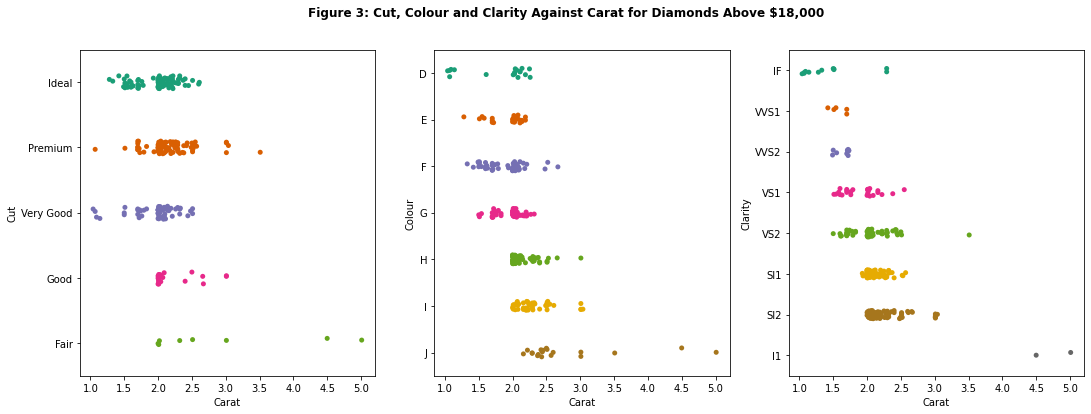

In [11]:
# Figure 3 to show carat against categorical features for most expensive diamonds
f, axs = plt.subplots(1, 3, figsize=(18, 6)) #fig with 1 row, 3 columns 
f.suptitle("Figure 3: Cut, Colour and Clarity Against Carat for Diamonds Above $18,000", weight ="bold")

# Strip plots for carat vs cut, colour, clarity categorical data 
sns.stripplot(x = "carat",
              y = "cut",
              order = ["Ideal", "Premium", "Very Good", "Good", "Fair"],
              data = high_price,
              palette = "Dark2",
              ax = axs[0])
axs[0].set(xlabel="Carat", ylabel="Cut")  # set axis labels 

sns.stripplot(x = "carat",
              y = "colour",
              order = ["D","E","F","G","H","I","J"], 
              data = high_price,
              palette = "Dark2",
              ax = axs[1]);
axs[1].set(xlabel="Carat", ylabel="Colour")  # set axis labels 

sns.stripplot(x = "carat",
              y = "clarity",
              order = ["IF","VVS1","VVS2","VS1","VS2","SI1","SI2","I1"],
              data = high_price,
              palette = "Dark2",
              ax = axs[2]);
axs[2].set(xlabel="Carat", ylabel="Clarity");  # set axis labels 



In [12]:
# Code to determine 'perfect' diamond for lowest price

# Concatenated query to find carat between 1-2 and only certain cut, colour, clarity
# Sort values lowest to highest, show first 5 observations 
dbi.query("(1 <= carat <= 2) \
          & (cut == ['Ideal','Premium', 'Very Good'])\
          & (colour == ['D','E','F','G'])\
          & (clarity == ['IF','VVS1','VVS2','VS1','VS2'])"
         )\
.sort_values("price")\
.head();
# Delete .head() & replace with .count() to show no of diamonds   

Further investigation into the highest priced diamonds, above \\$18,000, confirms that they are of a lower carat than expected. Figure 3 shows a subset of the 307 diamonds grouped by cut, colour and clarity against carat respectively. As the clarity or colour grade improves, the lower the carat of the diamond. This suggests that carat retention is also compromised when considering these two features. The high 4.5ct and 5ct diamond outliers have the worst cut, colour and clarity types and support the theory that they were cut only to retain carat. 

Figure 3 can assist in deciding the characteristics of a ‘perfect’ diamond. To choose a diamond to optimise beauty, it should be between 1–2ct. Diamonds outside of this range may be too small or large that either cut, clarity or colour are poor. Therefore, for the ‘perfect’ diamond, the cut type should ‘Ideal’-‘Very Good’, the diamond colour can be compromised down to grade G and the clarity compromised down to ‘VS2’. In this dataset there are 4438 diamonds that meet these criteria. The diamond with ID 10006 achieves these conditions with 1.01 carat, ‘Premium’ cut, colour ‘E’ and clarity ‘VS2’ for the lowest price of $4706. This should be the diamond a buyer should consider purchasing since it encapsulates all desired characteristics to optimise beauty for the cheapest price.

---
## 2-Unsupervised Learning

The K-Means clustering algorithm is used to group data points into clusters which are statistically similar to one another and least statistically similar to other clusters (Tan, et al., 2006). The number of clusters, K must be specified before the algorithm can begin. Once this has been chosen, K cluster centroids are randomly selected from the data points. The squared distance of every data observation and each of these cluster centroids is calculated and the observation is assigned to the closest cluster. The means of the K clusters are calculated, and these values become the respective new cluster centroids. The process is then iterated until the cluster assignments are stable (Steinley, 2010).

Several versions of K-means clustering were attempted with the diamond data, considering only numerical variables, excluding ‘price’ since this was the aimed feature to explain. Models with raw, standardised and dimensionally reduced data were created. Principle Component Analysis (PCA) was used to reduce the 6-dimensional data to 2-dimensional components (Shlens, 2014).

A disadvantage of the K-means algorithm is its reliance on the initial centroids chosen as this has an influence on the final clustering (Steinley, 2010). To combat this, the algorithm can be repeated N times with different centroids. The K-means performed in this analysis used the default N=10 and ‘k-means++’ to smartly select the initial centroids (Arthur & Vassilvitskii, 2006).

In [13]:
# Add log carat column to the dataframe since carat is skewed 
dbi["log_carat"] = np.log1p(dbi["carat"])

# Numerical variables only to be used in the clustering
# Price excluded since this is variable of interest 
num_vars = ["log_carat","depth","table","x","y","z"]

In [14]:
# Raw Data Clustering
seed(0) #set the seed so that random output remains constant

# Model defonition, 3 clusters, k-means++ to smart select centroids
estimator = KMeans(n_clusters = 3, init ="k-means++")  
estimator.fit(dbi[num_vars]) #fitting k-means model to the data

# Labels_ idicates which obs has been assigned which group
# Pandas series to attach cluster labels to the diamonds data index
# can see which diamond belongs to which cluster
k3_raw = pandas.Series(estimator.labels_, index=dbi.index)

In [15]:
# Standardised Data Clustering 

# Scale function standardises the data - subract mean from every val & divide by the standard deviation
dbi_stded = scale(dbi[num_vars]) 

# Create pandas dataframe with new std data where cols are vars used in clustering 
pandas.DataFrame(dbi_stded, 
                 index = dbi.index,
                 columns = num_vars)

# Use this df in the k=3 kmeans algorithm
seed(0) #set same seed
estimator = KMeans(n_clusters = 3, init="k-means++")  # k-means model as estimator
estimator.fit(dbi_stded) #fitting kmeans to standardised data

# mapping diamond ID with the new cluster assinment
k3_std = pandas.Series(estimator.labels_, index=dbi.index)

In [16]:
# Principle Component Analysis Clustering

# Define the model, pca reducing it from 6 dim to 2 dim
pca_estimator = PCA(n_components = 2)  

# Fit PCA estimator to the transformed 2 component data
components = pca_estimator.fit_transform(dbi[num_vars])  

# Create dataframe from components, where the cols are the 2 components
components = pandas.DataFrame(components,
                             index = dbi.index,
                             columns = ["Component-1", "Component-2"])

# Use this 2 dim df in the k=3 kmeans algorithm
seed(0) #set same seed
estimator = KMeans(n_clusters = 3, init="k-means++")  #k means model
estimator.fit(components) #2 dim components fitted to the kmeans

# map diamond ID with the new cluster assinment
k3_pca = pandas.Series(estimator.labels_, index = components.index)

**Clustering Quality**

The Calinski & Harabasz index (CHI) and Silhouette Coefficient (SC) are statistical measures which can be used to compare the quality of models (Arribas-Bel, 2021; Baarsch & Celebi, 2012). The CHI is a measure of the sum of dispersion between the clusters over the sum of dispersion of observations within their assigned clusters. A higher ratio indicates that clusters are dense and well separated. The SC is a measure of cohesion of points in the same cluster and separation of points to the next nearest cluster. A higher SC indicates that the model has better defined clusters (Baarsch & Celebi, 2012).

In [17]:
# Calculate CH Index/score for raw, standardised, PCA models using original data
chscore_raw = calinski_harabasz_score(dbi[num_vars], k3_raw) #for raw data
chscore_std = calinski_harabasz_score(dbi[num_vars], k3_std) #for stdised data
chscore_pca = calinski_harabasz_score(dbi[num_vars], k3_pca) #for 2 dim data

# Pandas series that shows the CH scores of each
ch=pandas.Series({"Raw": chscore_raw,
                  "Standardised": chscore_std,
                  "PCA": chscore_pca})

In [18]:
# Calculate Silhouette Coeff for raw, standardised, PCA models using original data
silscore_raw = silhouette_score(dbi[num_vars], k3_raw, metric="euclidean")
silscore_std = silhouette_score(dbi[num_vars], k3_std, metric="euclidean")
silscore_pca = silhouette_score(dbi[num_vars], k3_pca, metric="euclidean")

# Pandas series that shows the Silhouette scores of each
sil=pandas.Series({"Raw": silscore_raw,
                   "Standardised": silscore_std,
                   "PCA": silscore_pca})

In [19]:
# Create and display a pandas df/table with the CH and Silhouette scores for the 3 models
table1 = pandas.DataFrame({"Calinski & Harabasz Index": ch,"Silhouette Coefficient":sil})
table1.style.set_caption("Table 1: Performance Metrics for Clustering Models")

,Calinski & Harabasz Index,Silhouette Coefficient
Raw,26407.669185,0.305177
Standardised,10760.940266,0.189451
PCA,26391.080070,0.304286


Table 1 shows that the models using raw and PCA have considerably higher CHI and SC than the model using standardised data. From this it can be understood that the standardised model can be discarded since both measures reflect the low model performance. Overall, the raw model performs the best, however the PCA model measures are very similar. Since these measures are only indications of better performing models and not exact truths (Baarsch & Celebi, 2012), either of these two models may be used. Dimensionality reduction in PCA effectively handles multicollinear and dependant variables, such as the percentage depth and diamond dimensions (Shlens, 2014). Therefore, this version of K-means is better suited for the diamonds dataset to account for these relationships.

**Understanding Clusters (PCA-Model)**

In [20]:
# Create a second df with added cluster label column
newdbi = dbi.join(pandas.DataFrame({"cluster": k3_pca}), on="ID")

# Group the diamonds by their cluster assignment & give mean price/carat for each to 2 decimal places
cluster_info = newdbi.groupby("cluster")\
                            [["price","carat", "depth", "table", "x", "y", "z"]].mean().round(2)
#newdbi.groupby("cluster").count()  # Used to determine size of each cluster

In [21]:
# New labels for clusters for clarity 
mix_value= newdbi.query("cluster==0")
low_value = newdbi.query("cluster==1")
high_value = newdbi.query("cluster==2")

In [22]:
# Code to determine no of 'perfect' diamonds in each cluster

# Concatenated query to find carat between 1-2 and only certain cut, colour, clarity for all clusters
h=high_value.query("(1 <= carat <= 2) \
          & (cut == ['Ideal','Premium', 'Very Good'])\
          & (colour == ['D','E','F','G'])\
          & (clarity == ['IF','VVS1','VVS2','VS1','VS2'])"
         )['carat']\
.count() #count is 3502

m=mix_value.query("(1 <= carat <= 2) \
          & (cut == ['Ideal','Premium', 'Very Good'])\
          & (colour == ['D','E','F','G'])\
          & (clarity == ['IF','VVS1','VVS2','VS1','VS2'])"
         )['carat']\
.count() #count is 923

l=low_value.query("(1 <= carat <= 2) \
          & (cut == ['Ideal','Premium', 'Very Good'])\
          & (colour == ['D','E','F','G'])\
          & (clarity == ['IF','VVS1','VVS2','VS1','VS2'])"
         )['carat']\
.count() #count is 13

# Create pandas df/table to show 'perfect' diamond count & attach to cluster info
perf_cluster = pandas.DataFrame({"'perfect' diamond count": [m, l, h]})
cluster_info.join(perf_cluster)\
            .style.set_caption("Table 2: Mean of Features & 'Perfect' Diamond Count for Each Cluster")


,price,carat,depth,table,x,y,z,'perfect' diamond count
cluster,,,,,,,,
0,3895.170000,0.820000,60.780000,60.340000,5.850000,5.840000,3.550000,923
1,1317.260000,0.450000,61.940000,56.080000,4.850000,4.860000,3.010000,13
2,7355.150000,1.240000,62.230000,57.060000,6.790000,6.790000,4.220000,3502


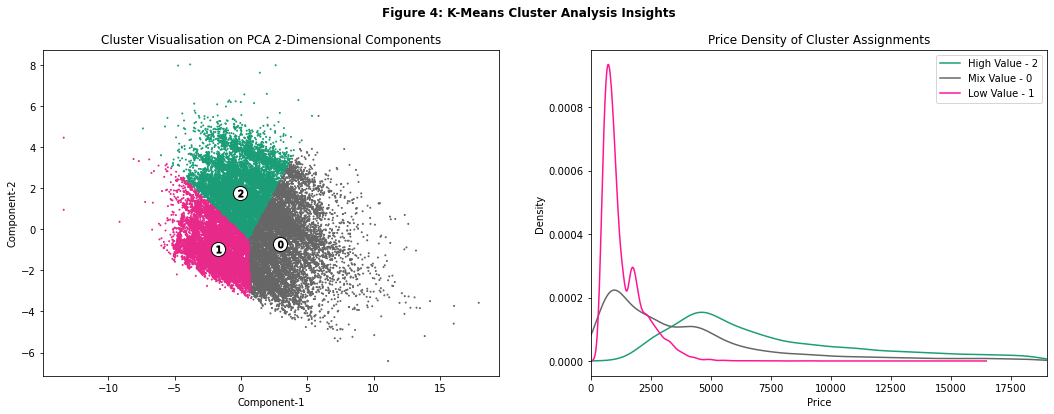

In [23]:
# Figure 4 to show clustering on PCA 2 component scatter plot & price kde plot
f, axs = plt.subplots(1, 2, figsize=(18, 6)) # figure with 1 row, 2 columns
f.suptitle("Figure 4: K-Means Cluster Analysis Insights", weight ="bold")

# first plot showing PCA clustering on components scatter plot
axs[0].title.set_text("Cluster Visualisation on PCA 2-Dimensional Components")

# scatter plot of the 2 dim data, colours now represent the clusters by PCA
components.assign(labels=k3_pca).plot.scatter("Component-1",
                                              "Component-2",
                                              c="labels",
                                              s=1, cmap="Dark2_r",
                                              colorbar=False,
                                              ax=axs[0]);

# Labeling the clusters, code adapted from:
# 'https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html'
centers = estimator.cluster_centers_  #cluster centroids
# Draw white circles with black outline at cluster centers
axs[0].scatter(centers[:, 0],
               centers[:, 1],
               marker='o',
               c="white",
               alpha=1,
               s=200,
               edgecolor="k")

# number each of the cluster centers
for i,c in enumerate(centers):
    axs[0].scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

# 2nd plot, price densisity distribution of each cluster
high_value["price"].plot.kde(legend=True, ax=axs[1], cmap = "Dark2")
mix_value["price"].plot.kde(legend=True, ax=axs[1], cmap = "Dark2_r")
low_value["price"].plot.kde(legend=True, ax=axs[1], color = "deeppink")
      
# control x and y label and limits for 2nd plot
axs[1].set(xlabel="Price")
axs[1].set(xlim=(0,19000))
axs[1].legend(["High Value - 2", "Mix Value - 0", "Low Value - 1"]);
axs[1].title.set_text("Price Density of Cluster Assignments")

In [24]:
%%capture
# Code used to investigate Depth density distrubution for only mixed cluster
f, ax = plt.subplots(1, figsize=(12, 6)) 
high_value["depth"].plot.kde(legend=True, cmap = "Dark2")
mix_value["depth"].plot.kde(legend=True, cmap = "Dark2_r")
low_value["depth"].plot.kde(legend=True, color = "deeppink")
ax.legend(["High Value - 2", "Mix Value - 0", "Low Value - 1"]);

# Code used to investigate frequency of cut,colour,clarity in mixed value cluster
f, ax = plt.subplots(1, 3, figsize=(18, 6)) 
f.suptitle("Frequency of Cut, Colour and Clarity for Mixed Value Cluster", weight ="bold")
mix_value["cut"].value_counts().plot.bar(cmap = "spring", ax=ax[0])
mix_value["colour"].value_counts().plot.bar(color = "orange", ax=ax[1])
mix_value["clarity"].value_counts().plot.bar(color = "y", ax=ax[2])
plt.show();

It was found that Cluster-0 was the smallest with 13,359 observations, followed by Cluster-2 with 17,573 observations and Cluster-1 with 22,840 observations. Table 2 shows that the clusters classification has been based on the value of the diamonds. The cluster mean price and carat leads to this interpretation. Cluster-2 can be regarded as higher value diamonds, Cluster-0 as medium value and Cluster-1 as lower value. Moreover, 3502 of the ‘perfect’ diamonds identified in Section 1 are present in the high value clustering and only 13 in the low value clustering, confirming that the diamonds have also been grouped based on their beauty. However, Figure 4 supports this for Clusters-1 and 2, but Cluster-0 appears to have a mixed price range.

Analysing the depth density distribution revealed that the mixed value cluster has a greater variation in depth percentage, and a higher table percentage, compared to the other clusters. Investigation into the frequency of cut types showed that the mixed cluster had an excess of ‘Premium’ cut diamonds and fewest ‘Ideal’ cut diamonds. The two other clusters consisted of mostly ‘Ideal’ cut diamonds, which is expected since almost half of the diamonds have this cut type (Figure 1). This difference may explain the reason behind the mixed value cluster assignment and why it has a greater price variation.

---
## 3 - Supervised Learning

Multiple linear regression can be used to make predictions of a dependant Y variable, based on several independent X variables (Schroeder, et al., 2017). These variables were the 4C’s and they were used to estimate diamond price (GIA, 2021).
A linear regression model using logarithmic price and raw price was tested to understand which model had better predictive performance. As this model by nature assumes that price is a linear function of the X variables, nonlinear random forest (RF) models were also created to investigate if this was a viable assumption (Breiman, 2001).

In [25]:
# Preparing X variables
# Create own dummy variables for the categorical variables since not auto created
# Binary vars, 1 if obs is part of category, 0 otherwise
X = dbi[["cut", "colour", "clarity"]]  # X vars to use in model

# Make dummy var for all 3 categories and drop first type from each
X = pandas.get_dummies(data = X, drop_first = True ) 

# Log carat continous var, since skewed, and add it to the X variables
X = pandas.concat([np.log1p(dbi["carat"]), X], axis = 1) 


In [26]:
# Preparing raw Y variable, aiming to predict this
Y = dbi["price"] 

# Set up linear regression model using func from scikit learn
raw_regressor = LinearRegression()  

# Train the linear regression model with raw price data
raw_regressor.fit(X, Y);      

# Recover the Y price predictions/model estimates
lraw_labels = raw_regressor.predict(X)

In [27]:
%%capture
# Code used to show coefficients the model has estimated
estimated_coefs = pandas.Series(raw_regressor.coef_, index = X.columns)  
print ("Estimated Regression Line Coeffs:\n", estimated_coefs)

The coefficients of the X variables estimate their effect on price when all other variables are held constant (Schroeder, et al., 2017). The estimated regression coefficients for the raw price linear model showed that a unit increase in carat increased price by \\$16,848.10. The categorical cut and clarity coefficients had an increase in price compared to ‘Fair’ and ‘I1’ respectively, whereas colour coefficients decreased in price compared to colour ‘D’, which reflected the exact order of their gradings.

In [28]:
# Train the linear regression model with log price data

# Calculate log of price
Y_log = np.log1p(dbi["price"])
log_regressor = LinearRegression()  #model to use
log_regressor.fit(X, Y_log);  #fit model to log of price

# Recover the Y price predictions/model estimates
llog_labels = log_regressor.predict(X)

In [29]:
# Train a Random Forest regresion model with raw price data

# n estimators = number of trees in the forest, used 100 trees 
# max features = size of the random subsets of features to consider when splitting a node
forest_raw = RandomForestRegressor(n_estimators = 100, max_features = None)
forest_raw.fit(X, Y) # fitting rf to data
    
# Recover the Y price predictions/model estimates
forest_raw_labels = forest_raw.predict(X)      

In [30]:
# Train Random Forest regression model with log price data

forest_log = RandomForestRegressor(n_estimators = 100, max_features = None) #model to use
forest_log.fit(X, Y_log) # fitting rf to data

# Recover the Y price predictions/model estimates
forest_log_labels = forest_log.predict(X)

In [31]:
# Create table of all 4 predictions (linear raw/linear log/forest raw/forest log) for comparision
res = pandas.DataFrame({"Linear-Raw": lraw_labels,
                        "Linear-Log": llog_labels,
                        "Random Forest-Raw": forest_raw_labels,
                        "Random Forest-Log": forest_log_labels,
                        "Observed Price": dbi["price"]})

**Model Performance**

Several metrics were used to evaluate the relative model performance. The $R^2$ score was used to indicate the proportion of price variation explained by the model, Root Mean Squared Error (RMSE) to indicate the amount each price prediction on average may be incorrectly reported and the Mean Absolute Error (MAE) to indicate the average price difference between estimated and observed (Botchkarev, 2018).

In [32]:
# R2 score performance metric
# Create pandas series with R2 for all 4 models, using observed price and model predicted prices
r2s = pandas.Series({"Model 1: Linear-Raw": r2_score(res["Observed Price"], 
                                                     res["Linear-Raw"]),
                     
                     "Model 2: Linear-Log": r2_score(np.log1p(res["Observed Price"]),
                                                     res["Linear-Log"]),
                     
                     "Model 3: Random Forest-Raw": r2_score(res["Observed Price"],
                                                            res["Random Forest-Raw"]),
                     
                     "Model 4: Random Forest-Log": r2_score(np.log1p(res["Observed Price"]),
                                                            res["Random Forest-Log"])
                    })

In [33]:
# Mean Squared Error (MSE) performance metric
# Create pandas series with MSE for all 4 models, using observed price and model predicted prices
mses = pandas.Series({"Model 1: Linear-Raw": mse(res["Observed Price"], 
                                                 res["Linear-Raw"]),
                      
                      "Model 2: Linear-Log": mse(res["Observed Price"],
                                                 np.exp(res["Linear-Log"])),
                      
                      "Model 3: Random Forest-Raw": mse(res["Observed Price"],
                                                        res["Random Forest-Raw"]),
                      
                      "Model 4: Random Forest-Log": mse(res["Observed Price"],
                                                        np.exp(res["Random Forest-Log"]))
                     }).apply(np.sqrt)

In [34]:
# Mean Average Error (MAE) performance metric
# Create pandas series with MAE for all 4 models, using observed price and model predicted prices
mae=metrics.mean_absolute_error
maes = pandas.Series({"Model 1: Linear-Raw": mae(res["Observed Price"], 
                                                 res["Linear-Raw"]),
                      
                      "Model 2: Linear-Log": mae(res["Observed Price"],
                                                 np.exp(res["Linear-Log"])),
                      
                      "Model 3: Random Forest-Raw": mae(res["Observed Price"],
                                                        res["Random Forest-Raw"]),
                      
                      "Model 4: Random Forest-Log": mae(res["Observed Price"],
                                                        np.exp(res["Random Forest-Log"]))
                     })

In [35]:
# Create dataframe from performance metric pandas series & display table
perf = pandas.DataFrame({"R^2": r2s,
                         "RMSE": mses,
                         "MAE": maes})
perf.style.set_caption("Table 3: Performance Metrics for Regression Models")

,R^2,RMSE,MAE
Model 1: Linear-Raw,0.877449,1395.254856,1055.822796
Model 2: Linear-Log,0.958095,2579.652105,848.261950
Model 3: Random Forest-Raw,0.989987,398.813299,211.271163
Model 4: Random Forest-Log,0.993035,399.270074,212.047543


From Table 3, all $R^2$ values for the models are very high and almost equal to 1, with Model 4 performing the best. A score close to 1 suggests that the model can explain nearly all price variation. However, the RMSE scores are significantly higher for the linear models than the nonlinear models, which have a lower \\$400 error in price predictions. Although RMSE scores are a better metric to use when dealing a dataset with outliers (Botchkarev, 2018), the MAE scores also show that the linear models perform worse than the nonlinear. Therefore, using only the figures in Table 3, Model 3 should be used as this minimises RMSE, MAE and maximises $R^2$.

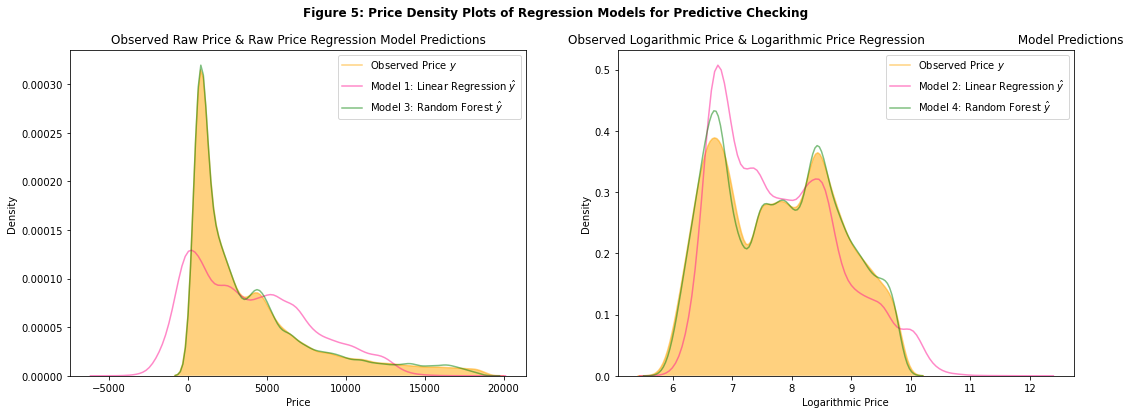

In [36]:
# Figure 5 to show predictive accuracy of the 4 models 
f, axs = plt.subplots(1, 2, figsize=(18, 6)) # figure with 1 row, 2 columns
f.suptitle("Figure 5: Price Density Plots of Regression Models for Predictive Checking",
           weight ="bold") #set main figure title

# Raw observed price KDE plot & Raw linear/RF kde plots for comparision
# Observed raw price kde plot
sns.kdeplot(Y, shade=True,
            alpha =0.5,
            label="Observed Price $y$",
            color="orange",
            ax=axs[0]) 
# linear raw model price predictions
sns.kdeplot(lraw_labels,
            alpha =0.5,
            label="Model 1: Linear Regression $\hat{y}$",
            color="deeppink",
            ax=axs[0]); 
# random forest raw model price predictions
sns.kdeplot(forest_raw_labels,
            alpha =0.5,
            label="Model 3: Random Forest $\hat{y}$",
            color="green",
            ax=axs[0]) 

# set title for 1st plot
axs[0].title.set_text("Observed Raw Price & Raw Price Regression Model Predictions") 
axs[0].set(xlabel="Price", ylabel="Density")  # set 1st plot axis labels 


# Log observed price KDE plot & Log linear/RF kde plots for comparision 
# Observed log price kde plot
sns.kdeplot(Y_log,
            shade=True,
            alpha =0.5,
            label="Observed Price $y$",
            color="orange",
            ax=axs[1]) 
# linear log model price predictions
sns.kdeplot(llog_labels,
            alpha =0.5,
            label="Model 2: Linear Regression $\hat{y}$",
            color="deeppink",
            ax=axs[1]) 
# Random Forest log model price predictions
sns.kdeplot(forest_log_labels,
            alpha =0.5,
            label="Model 4: Random Forest $\hat{y}$",
            color="green",
            ax=axs[1]) 

axs[1].title.set_text("Observed Logarithmic Price & Logarithmic Price Regression\
                        Model Predictions") # set title for 1st plot
axs[1].set(xlabel="Logarithmic Price", ylabel="Density")  # set axis label

plt.show()

However, the very high $R^2$ for all models suggests that they may be severely overfit (Colton & Bower, 2002). Figure 5 shows that both RF models fit almost the exact shape of the original dataset. Model 1 fails to fit predictions to the original data and, on this basis, should be discarded. Model 4 appears to follow the shape of the original data, with only some over-estimating.

In [37]:
# 5-fold cross validation for raw price linear model
lraw_kcv_mses = cross_val_score(LinearRegression(),
                              X,
                              dbi["price"],
                              cv=5,
                              scoring="neg_mean_squared_error")

# Calculate average MSE from 5 models, square root to present RMSE in USD units
print("RMSE for Raw Price Linear Regression Model: ", np.sqrt(-lraw_kcv_mses).mean())

RMSE for Raw Price Linear Regression Model:  1729.3171388433755


In [38]:
# 5-fold cross validation for raw price nonlinear random forest model
seed(0) #set seed for random outputs to remain constant
rf_estimator = RandomForestRegressor(n_estimators=100, max_features=None) #rf regressor model

rf_kcv_mses = cross_val_score(rf_estimator,
                              X,
                              dbi["price"],
                              cv=5,
                              scoring="neg_mean_squared_error")
# Calculate average MSE from 5 models, square root to present RMSE in USD units
print("RMSE for Raw Price Random Forest Model: ", np.sqrt(-rf_kcv_mses).mean())


RMSE for Raw Price Random Forest Model:  1502.0363173881246


Cross-validation (CV) was used to combat the problem of overfitting, which is where the data is split into ‘test’ and ‘training’ sets. The model is fitted to the ‘training’ set and model predictions are made using the ‘test’ set (Borra & Di Ciaccio, 2010). This method is advantageous since the model performance can be evaluated based on unseen test data, minimising the risk of overfitting (Breiman, 2001). K-fold cross validation for Models 1 and 3 was used with k=5 to provide a less biased RMSE. This is because in 5-fold CV, the dataset is split into 5 subsets and the model is trained 5 times on 4 subsets, then tested on the remaining subset (Borra & Di Ciaccio, 2010). The cross-validated linear model had a slightly higher but similar RMSE of \\$1729.32, compared its original RMSE of \\$1395.25. However, the cross-validated RF model had a significant increase in RMSE, going from \\$398.49 to \\$1502.04. This increase in error suggests that the RF model performs considerably worse when presented with unseen data and cannot make accurate predictions. Therefore, after using cross-validation, the ‘best’ model from those presented would be the linear model, in particular Model 2 which also accounts for the skewed price distribution. As error scores are still relatively high, an alternative nonlinear model such as neural networks could be better suited to the diamonds dataset and may provide more accurate predictions (Cardoso & Chambel, 2005).

---
## References

Arribas-Bel, D., 2021. _Data Science Studio_. [Online] 
Available at: https://darribas.org/data_science_studio/content/assessment.html
[Accessed 02 02 2021].

Arthur, D. & Vassilvitskii, S., 2006. _k-means++: The Advantages of Careful Seeding_, California: Stanford.

Baarsch, J. & Celebi, M. E., 2012. _Investigation of Internal Validity Measures for K-Means Clustering_. Hong Kong, Proceedings of the International MultiConference of Engineers and Computer Scientists.

Borra, S. & Di Ciaccio, A., 2010. Measuring the Prediction Error. A Comparison of Cross-Validation, Bootstrap and Covariance Penalty Methods. _Computational Statistics & Data Analysis_, 54(12), pp. 2976-2989.

Botchkarev, A., 2018. _Performance Metrics (Error Measures) in Machine Learning Regression, Forecasting and Prognostics: Properties and Typology_, New York: Cornell Univeristy.

Breiman, L., 2001. Statistical Modeling: The Two Cultures. _Statistical Science_, 16(3), p. 199–231.

Cardoso, M. G. M. S. & Chambel, L., 2005. A Valuation Model for Cut Diamonds. _International Transactions in Operational Research_, 12(4), pp. 417-436.

Colton, J. A. & Bower, K. M., 2002. Some Misconceptions About R2. _International Society of Six Sigma Professionals, EXTRAOrdinary Sense_, 3(2), pp. 20-22.

GIA, 2021. _Diamond Quality Factors_. [Online] 
Available at: https://www.gia.edu/diamond-quality-factor
[Accessed 02 02 2021].

Kaggle, 2017. _Diamonds_. [Online] 
Available at: https://www.kaggle.com/shivam2503/diamonds
[Accessed 02 02 2021].

Schroeder, L. D., Sjoquist, D. L. & Stephan, P. E., 2017. _Understanding Regression Analysis: An Introducotry Guide_. 2nd ed. Thousand Oaks: SAGE Publications, Inc.

Shlens, J., 2014. A Tutorial on Principal Component Analysis. _International Journal of Remote Sensing_, 51(2), pp. 1-12.

Steinley, D., 2010. K‐means clustering: A half‐century synthesis. _British Journal of Mathematical and Statistical Psychology_, 59(1), pp. 1-34.

Tan, P. N., Steinbach, M., Karpatne, A. & Kumar, V., 2006. Chapter 8: Cluster Analysis: Basic Concepts and Algorithms. In: _Introduction to Data Mining Lecture Notes_. Minnesota: Univeristy of Minnesota, pp. 487-568.